In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision.datasets.mnist import MNIST

import torchvision.transforms as transforms

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt


# Part of the training and accuracy check were taken from assigment-2

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

def check_accuracy_part(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
def train_part(model, optimizer, epochs=1):
    """
    Train a model on MNIST using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    best_acc = -1
    best_model = None
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(data_train_loader):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc = check_accuracy_part(data_test_loader, model)
                if acc > best_acc:
                    best_acc = acc
                    best_model = model
                print()
    print('Best accuracy found', best_acc)
    return best_model


In [2]:
dtype = torch.float32

if 0:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
if 1:

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = dset.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    data_train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                              shuffle=True)

    testset = dset.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    data_test_loader = torch.utils.data.DataLoader(testset, batch_size=512,
                                             shuffle=False)

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    print_every = 50
    print('using device:', device)

    # Neural network architecture
    # Current code only supports conv2d-ReLU-maxPool2d pairs together and Linear
    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        nn.Conv2d(32, 16, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),

        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        Flatten(),

        nn.Linear(4*4*32, 10),
    )

else:
    data_train = MNIST('./data/mnist',
                       download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor()]))

    data_test = MNIST('./data/mnist',
                      train=False,
                      download=True,
                      transform=transforms.Compose([
                          transforms.Resize((32, 32)),
                          transforms.ToTensor()]))

    data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True)
    data_test_loader = DataLoader(data_test, batch_size=1024)


    print_every = 50
    print('using device:', device)


    # Lenet-5 architecture
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        Flatten(),
        nn.Linear(5*5*16, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10),
    )    
    

#optimizer = optim.SGD(model.parameters(), lr=2e-2, momentum=0.9, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr=2e-3)

best_model = train_part(model, optimizer, 1)

print(best_model)

Files already downloaded and verified
Files already downloaded and verified
using device: cpu
Iteration 0, loss = 2.3014
Checking accuracy on test set
Got 1531 / 10000 correct (15.31)

Iteration 50, loss = 1.7903
Checking accuracy on test set
Got 3495 / 10000 correct (34.95)

Iteration 100, loss = 1.6537
Checking accuracy on test set
Got 4139 / 10000 correct (41.39)

Iteration 150, loss = 1.4941
Checking accuracy on test set
Got 4434 / 10000 correct (44.34)

Iteration 200, loss = 1.5200
Checking accuracy on test set
Got 4762 / 10000 correct (47.62)

Iteration 250, loss = 1.4983
Checking accuracy on test set
Got 4940 / 10000 correct (49.40)

Iteration 300, loss = 1.3910
Checking accuracy on test set
Got 5268 / 10000 correct (52.68)

Iteration 350, loss = 1.2146
Checking accuracy on test set
Got 5431 / 10000 correct (54.31)

Best accuracy found 0.5431
Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)
torch.Size([512, 10])
tensor([-4.4179, -3.4760, -1.3760,  1.9832, -1.7233,  0.8797,  1.5725,  1.5281,
        -5.1987,  0.1329], grad_fn=<SelectBackward>) 
 prediction: tensor(3)
3 32 32
2 2
2 2
2 2
torch.Size([512, 10])
Conv layer
w_0_weight_2d (32, 3, 5, 5)
Conv layer
w_3_weight_2d (16, 32, 5, 5)
Conv layer
w_6_weight_2d (32, 16, 5, 5)
linear layer
w_10_weight_2d (10, 512)


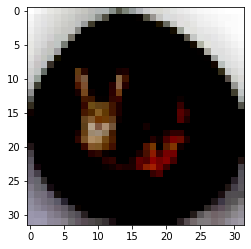

In [5]:
# weights header and network generator. This generates main.h and main.c
weights_file = open('main.h', 'w')
weights_file.write('typedef float data_t;\n\n')

c_file = open('main.c', 'w')
c_file.write('#include <stdio.h>\n\
#include <string.h>\n\
#include <stdint.h>\n\
#include "main.h"\n\
#include "helper_functions.h"\n\
\n')

c_file.write('\n\
int main()\n\
{\n')


sample_vector_batch = None

for i, (images, labels) in enumerate(data_test_loader):
    if i == 1:
        selected_in_batch = 3

        img = images[selected_in_batch].numpy()
        print(img.shape)
        #plt.imshow(img.reshape(32,32), vmin=0, vmax=1)
        plt.imshow(img.transpose(1,2,0), vmin=0, vmax=1)
        
        sample_vector_batch = images
        
        weights_file.write('const data_t test['+str(img.size)+']={')
        np.savetxt(weights_file, images[selected_in_batch].flatten(), newline=',')
        weights_file.write('};\n')

        images = images.to(device=device, dtype=dtype)  # move to device, e.g. GPU
        #output = lenet_debug(images)
        output = best_model(images)
        print(output.shape)
        _, preds = output.max(axis=1)
        #print(output[selected_in_batch, 0])
        print(output[selected_in_batch], '\n prediction:', preds[selected_in_batch])
        break

result = sample_vector_batch
input_size = result.shape[1]*result.shape[2]*result.shape[3]
L = np.empty(0)
L = np.append(L, np.uint32(input_size))

print(result.shape[1], result.shape[2], result.shape[3])

previous_padding = None

index = 0

meta_list = list()

c_file.write('\t twoD_t meta_data'+str(index)+' = {\n\
                           .r = '+ str(result.shape[2]) +',\n\
                           .c = '+str(result.shape[3])+',\n\
                           .channel = '+str(result.shape[1])+',\n\
                           .data = buffer'+str(index%2)+',\n\
                           .bias = NULL\n\
                       };\n\n')

meta_list.append(('meta_data'+str(index),(0,0,0)))

for i in best_model:
    result = i(result)
    if 'Conv2d' in str(i):
        previous_padding = i.padding[0]
    if 'ReLU' in str(i):
        continue
    if 'MaxPool' in str(i):
        index += 1
        print(i.stride, i.kernel_size)
        L = np.append(L, result.shape[1]*result.shape[2]*result.shape[3])
        c_file.write('\t twoD_t meta_data'+str(index)+' = {\n\
                           .r = '+str(result.shape[2])+',\n\
                           .c = '+str(result.shape[3])+',\n\
                           .channel = '+str(result.shape[1])+',\n\
                           .data = buffer'+str(index%2)+',\n\
                           .bias = NULL\n\
                       };\n\n')        
        meta_list.append(('meta_data'+str(index),(i.stride, i.kernel_size, previous_padding)))
    
    if 'Linear' in str(i):
        index += 1
        print(result.shape)
        L = np.append(L, result.shape[1])
        c_file.write('\t twoD_t meta_data'+str(index)+' = {\n\
                           .r = '+str(result.shape[1]) +',\n\
                           .c = 1,\n\
                           .channel = 1,\n\
                           .data = buffer'+str(index%2)+',\n\
                           .bias = NULL\n\
                       };\n\n')
        meta_list.append(('meta_data'+str(index),(0,0,0)))

c_file.write('\n\t memcpy(buffer0, test, sizeof(test));\n')

c_file.write('\n\t printf("---Network starts---\\n");\n')


inx = np.argsort(L)

weights_file.write('\n\
data_t buffer'+str(inx[-1]%2)+'['+str(int(L[inx[-1]]))+'];\n\
data_t buffer'+str((inx[-1]+1)%2)+'['+str(int(L[inx[-2]]))+'];\n\
\n\
typedef struct twoD\n\
{\n\
	uint32_t r;\n\
	uint32_t c;\n\
	uint32_t in_channel;\n\
	uint32_t channel;\n\
	data_t *data;\n\
	data_t *bias;\n\
} twoD_t;\n\n')

prev_shapes = None
prev_arr_name = None

index = 0
for name, param in best_model.state_dict().items():

    arr = param.cpu().numpy();
    shape_of_params = arr.shape
    param_size =  len(arr.flatten())
    #print(name, 'param size:', param_size)
    underscore_arr_name = 'w_'+name.replace('.', '_')
    array_name  = underscore_arr_name + '[' + str(param_size) + ']=' 
    weights_file.write('const data_t '+array_name+'{')
    np.savetxt(weights_file, arr.flatten(), newline=',')
    weights_file.write('};\n\n')

    if len(shape_of_params) == 1:
        index += 1
        if len(prev_shapes) > 2:
            print('Conv layer')
            out_channel = prev_shapes[0]
            in_channel = prev_shapes[1]
            c_file.write('\t conv2D(&'+meta_list[index-1][0]+', &'+prev_arr_name+'_2d, &'+meta_list[index][0]+', &reLU, '+str(meta_list[index][1][0])+', '+str(meta_list[index][1][1])+', '+str(meta_list[index][1][1])+', '+str(meta_list[index][1][2])+');\n')
            
        else:
            print('linear layer')
            out_channel = 1
            in_channel = 1
            if len(meta_list) == (index+1):
                c_file.write('\t dot(&'+meta_list[index-1][0]+', &'+prev_arr_name+'_2d, &'+meta_list[index][0]+', NULL);\n')
            else:
                c_file.write('\t dot(&'+meta_list[index-1][0]+', &'+prev_arr_name+'_2d, &'+meta_list[index][0]+', &reLU);\n')
                
        weights_file.write('const twoD_t '+prev_arr_name+'_2d = {\n\
                           .r = '+ str(prev_shapes[-1]) +',\n\
                           .c = '+str(prev_shapes[-2])+',\n\
                           .in_channel = '+str(in_channel)+',\n\
                           .channel = '+str(out_channel)+',\n\
                           .data = '+prev_arr_name+',\n\
                           .bias = '+underscore_arr_name+'\n\
                       };\n\n')
        print(prev_arr_name+'_2d', prev_shapes)

    prev_shapes = shape_of_params
    prev_arr_name = underscore_arr_name

c_file.write('\n\t print_twoD(&'+meta_list[-1][0]+', 0);\n')
c_file.write('\t printf("PREDICTION: %d\\n", get_class(&'+meta_list[-1][0]+'));\n')

class network_partial(nn.Module):
    def __init__(self, original_model):
        super(network_partial, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-6])
        
    def forward(self, x):
        x = self.features(x)
        return x

intermediate_results= network_partial(best_model)

weights_file.close()

c_file.write('\t return 0;\n}')

c_file.close()